# Création du dataset

## Importation des packages

In [145]:
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import requests
from io import BytesIO
from zipfile import ZipFile, BadZipFile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data
# import pandas_datareader.data as web
from sklearn.datasets import fetch_openml
import seaborn as sns
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)


np.random.seed(167)

## Vérification des versions

In [146]:
print('Python  version {}'.format(sys.version))
print('Numpy   version {}'.format(np.__version__))
print('Pandas  version {}'.format(pd.__version__))
print('Seabron version {}'.format(sns.__version__))
print('Sklearn version {}'.format(sk.__version__))

Python  version 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Numpy   version 1.20.3
Pandas  version 1.3.2
Seabron version 0.11.2
Sklearn version 1.0.1


## Récupération des données 

On utilise ici le package pandas_datareader pour avoir accès aux informations quotidiennes quand aux prix des ETF et actions d'entreprises.

In [147]:
# On récupère d'abord toutes les informations sur les différents produits financiers référencés par Yahoo Finance
all_tickers = data.get_nasdaq_symbols()

# On filtre pour n'avoir que les actions (hors ETF), traitées par le NASDAQ et ne renvoyant pas d'erreur
tickers = all_tickers[(all_tickers['Nasdaq Traded']) & (~all_tickers["Test Issue"]) & (~all_tickers["ETF"])]

# On en extrait la liste des noms
tickers_symbols = tickers["NASDAQ Symbol"].to_list()

On se focalise sur les 100 entreprises avec la plus grande capitalisation boursière

Le code suivant permet d'extraire l'ensemble des capitalisations boursière des entreprises connues de Yahoo Finance. Cependant il prend une heure d'execution. Aussi j'ai extrait le fichier au format .csv afin de pouvoir l'utiliser directement.

In [148]:
# market_cap = data.get_quote_yahoo(tickers_symbols[0])[["marketCap"]]
# for ticker in tickers_symbols[1:] :
#     try :
#         market_cap = market_cap.append(data.get_quote_yahoo(ticker)[["marketCap"]])
#     except :
#         pass
# market_cap

In [149]:
# Chargement du fichier comportement les capitalisations boursières
market_cap = pd.read_csv("data/market_cap.csv", index_col="Unnamed: 0")
market_cap

,marketCap
A,48856465408
AA,9126754304
AAC,1227499904
AACG,67463472
AACI,202746000
...,...
ZWRK,280600000
ZY,970184512
ZYME,873998144
ZYNE,169543664


In [159]:
top100_market_cap = market_cap.marketCap.nlargest(50)
top100_market_cap

MSFT     2543110062080
AAPL     2454233284608
GOOGL    2002242109440
GOOG     1958893977600
AMZN     1786169393152
TSLA     1011429081088
FB        971627167744
GE        903014842368
TSM       610479374336
JPM       501469380608
V         468898611200
BABA      456106868736
UNH       430115127296
JNJ       430113226752
HD        412279078912
BAC       401494081536
WMT       401225809920
PG        362362503168
MA        360141520896
ASML      354620014592
ADBE      316354658304
NFLX      301066190848
DIS       289691336704
CRM       281991184384
XOM       275311329280
PFE       274299682816
NKE       273935220736
ORCL      267222319104
NVO       264960622592
TM        259419389952
TMO       255110561792
PYPL      250276233216
LLY       247217471488
CMCSA     245874458624
KO        244299792384
CSCO      242000429056
ACN       234642014208
ABT       232016265216
COST      231611236352
AVGO      231405649920
PEP       226518220800
CVX       226026487808
DHR       218976649216
VZ        2

In [197]:
# idx = pd.IndexSlice
# stocks.loc[idx[top100_market_cap.index]]

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2011-01-01'
end_date = '2021-11-16'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
stocks = data.DataReader(top100_market_cap.index, 'yahoo', start_date)[["Adj Close"]].pct_change()

stocks

Attributes Adj Close                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Symbols         MSFT      AAPL     GOOGL      GOOG      AMZN      TSLA        FB        GE       TSM       JPM         V      BABA       UNH       JNJ        HD       BAC       WMT        PG        MA      ASML      ADBE      NFLX       DIS       CRM       XOM       PFE       NKE      ORCL       NVO        TM       TMO      PYPL       LLY     CMCSA        KO      CSCO       ACN       ABT      COST      AVGO       PEP       CVX       DHR        VZ       MRK       WFC      SHOP      ABBV      INTC      QCOM
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2011-01-03       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN
2011-01-04  0.003931  0.005219 -0.003690 -0.003690  0.004288  0.001878       NaN  0.018052  0.003177  0.014473  0.001134       NaN  0.009158  0.008437 -0.018125  0.003524  0.003849  0.002779  0.012905 -0.032851  0.007031  0.016591  0.030936 -0.006662  0.004694  0.017534 -0.024626 -0.004428  0.032287  0.005414  0.004605       NaN  0.000857  0.003129 -0.020699  0.001464 -0.006586  0.009410 -0.001932  0.007194 -0.005171 -0.003698 -0.005722  0.020038  0.008602  0.002216       NaN       NaN  0.014388  0.015743
2011-01-05 -0.003204  0.008180  0.011543  0.011543  0.013026  0.005999       NaN  0.001612 -0.021378  0.012229  0.021105       NaN  0.003202 -0.000632 -0.003173  0.018258 -0.006573 -0.002310  0.029459 -0.020326  0.022533 -0.009042  0.024878  0.047977 -0.002670  0.006670  0.006550 -0.013977  0.006534  0.004257 -0.003526       NaN -0.007136  0.013369 -0.005950  0.012183  0.000207  0.000000 -0.018527 -0.000357  0.018040 -0.001746 -0.001065  0.013725  0.005777  0.022749       NaN       NaN -0.009929  0.020796
2011-01-06  0.029286 -0.000808  0.007273  0.007273 -0.008324  0.039135       NaN -0.004292  0.041262 -0.004922  0.014981       NaN  0.020750 -0.001579 -0.004051 -0.004138 -0.008271 -0.001697  0.004258 -0.008463  0.001552 -0.009681 -0.007758  0.008017  0.006426  0.003865 -0.008992  0.004188 -0.002597  0.016708  0.001062       NaN  0.004600  0.000879 -0.007245  0.008667  0.003728 -0.002071 -0.004789  0.018935  0.003754 -0.008202  0.000640 -0.025604  0.013676 -0.006796       NaN       NaN -0.008119  0.012301
2011-01-07 -0.007634  0.007161  0.004792  0.004792 -0.001991  0.012912       NaN -0.007005  0.015540 -0.018885 -0.002870       NaN  0.002085 -0.009651 -0.001162 -0.013158  0.002224 -0.002937 -0.000130 -0.000276 -0.007127  0.007360 -0.005044 -0.007814  0.005454  0.008801 -0.002746 -0.004492 -0.009372  0.011283 -0.003712       NaN -0.001145 -0.002636 -0.001745  0.000954  0.001651  0.004152  0.000000 -0.008415 -0.006732  0

In [198]:
stocks.columns = [k[1] for k in stocks.columns.values]

## Préparation des données

In [200]:
stocks = stocks.dropna(thresh=int(stocks.shape[0] * .95), axis=1)
stocks = stocks.dropna(thresh=int(stocks.shape[1] * .95))
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2738 entries, 2011-01-04 to 2021-11-17
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MSFT    2738 non-null   float64
 1   AAPL    2738 non-null   float64
 2   GOOGL   2738 non-null   float64
 3   GOOG    2738 non-null   float64
 4   AMZN    2738 non-null   float64
 5   TSLA    2738 non-null   float64
 6   GE      2738 non-null   float64
 7   TSM     2738 non-null   float64
 8   JPM     2738 non-null   float64
 9   V       2738 non-null   float64
 10  UNH     2738 non-null   float64
 11  JNJ     2738 non-null   float64
 12  HD      2738 non-null   float64
 13  BAC     2738 non-null   float64
 14  WMT     2738 non-null   float64
 15  PG      2738 non-null   float64
 16  MA      2738 non-null   float64
 17  ASML    2738 non-null   float64
 18  ADBE    2738 non-null   float64
 19  NFLX    2738 non-null   float64
 20  DIS     2738 non-null   float64
 21  CRM     2738 non-nu

## Analyse des covariances

In [201]:
cov = stocks.cov()

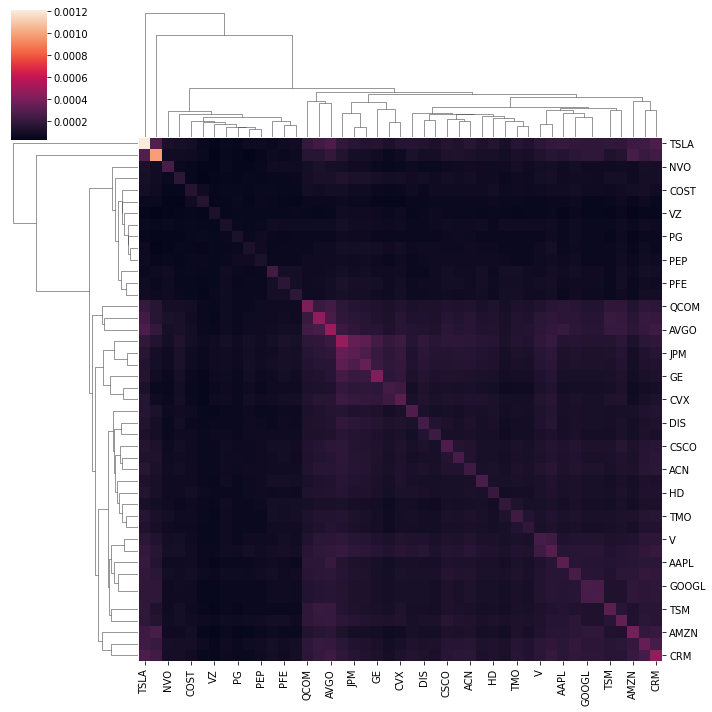

In [202]:
sns.clustermap(cov);

## PCA

In [203]:
pca = PCA()
pca.fit(cov)
pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance').head().style.format('{:,.2%}'.format)

,Explained Variance
0,46.40%
1,18.04%
2,12.10%
3,6.35%
4,2.73%


In [204]:
top4 = pd.DataFrame(pca.components_[:4], columns=cov.columns)
eigen_portfolios = top4.div(top4.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(1, 5)]

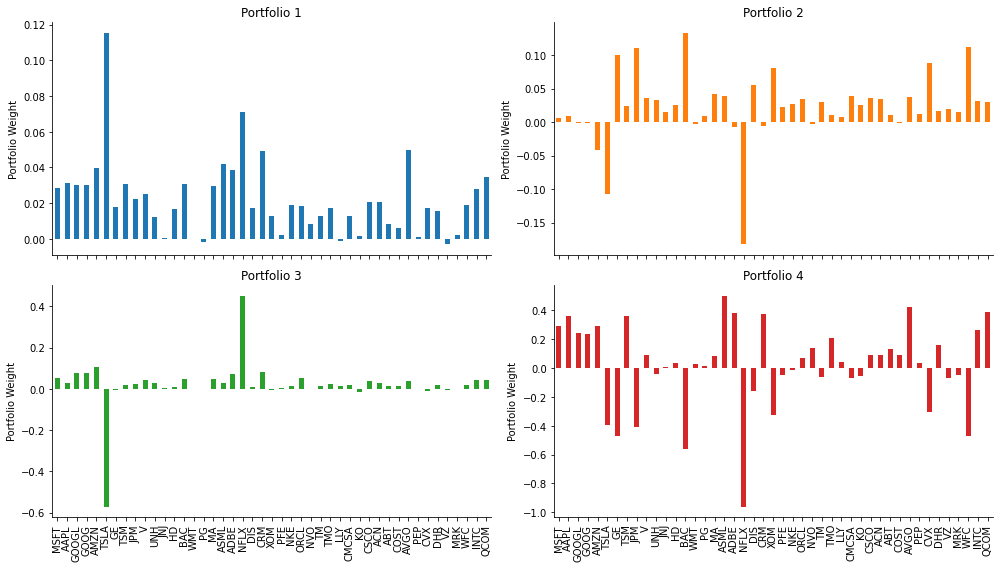

In [205]:
axes = eigen_portfolios.T.plot.bar(subplots=True,
                                   layout=(2, 2),
                                   figsize=(14, 8),
                                   legend=False)
for ax in axes.flatten():
    ax.set_ylabel('Portfolio Weight')
    ax.set_xlabel('')
sns.despine()
plt.tight_layout()

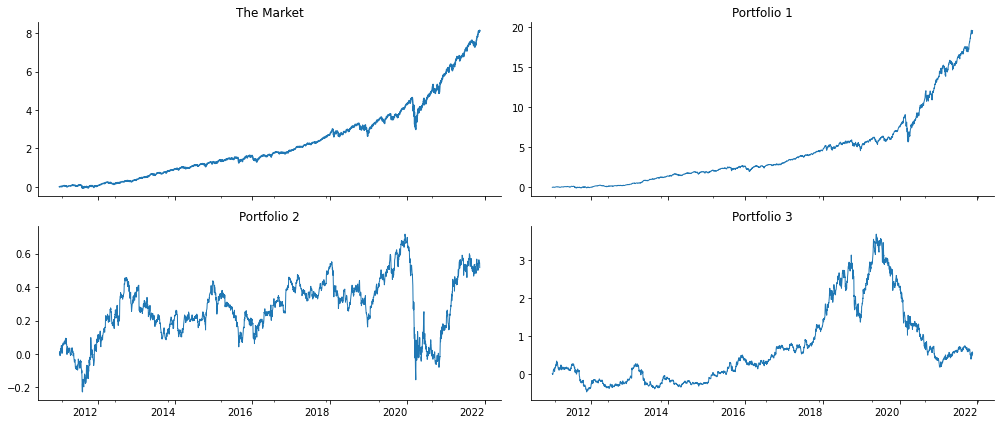

In [207]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True)
axes = axes.flatten()
stocks.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0])
for i in range(3):
    rc = stocks.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1)
    rc.plot(title=f'Portfolio {i+1}', ax=axes[i+1], lw=1, rot=0)

for i in range(4):
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()

## Tests

### Quandl

In [6]:
import quandl

# Chargement de la clé d'API 
api_key = open("data/nasdaq_api_key.txt", "r")
quandl.ApiConfig.api_key = api_key.readline()

In [20]:
data = quandl.get("WIKI/AAPL", rows=5)
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0


### pandas_datareader

In [4]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
data.get_quote_yahoo(tickers)[['marketCap']]

,marketCap
AAPL,2.460960e+12
MSFT,2.523207e+12
^GSPC,NaN


In [7]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['AAPL', 'MSFT', '^GSPC']

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2021-11-15'
end_date = '2016-12-31'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(tickers, 'yahoo', start_date)

In [8]:
panel_data['Adj Close'].head()

Symbols,AAPL,MSFT,^GSPC
Date,,,
2021-11-15,150.0,336.070007,4682.799805
2021-11-15,150.0,336.070007,4682.799805


In [44]:
panel_data['Adj Close'].describe()

Symbols,AAPL,MSFT,^GSPC
count,220.000000,220.000000,220.000000
mean,136.483590,266.799823,4215.275041
std,10.356021,31.873363,259.283378
min,115.819870,210.870728,3700.649902
25%,127.028629,241.307781,3961.669983
50%,134.622185,259.438171,4226.889893
75%,146.336533,293.341766,4424.637451
max,156.461655,336.989990,4701.700195


In [70]:
all_tickers = data.get_nasdaq_symbols()
all_tickers

,Nasdaq Traded,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
Symbol,,,,,,,,,,,
A,True,"Agilent Technologies, Inc. Common Stock",N,,False,100.0,False,NaN,A,A,False
AA,True,Alcoa Corporation Common Stock,N,,False,100.0,False,NaN,AA,AA,False
AAA,True,Listed Funds Trust AAF First Priority CLO Bond...,P,,True,100.0,False,NaN,AAA,AAA,False
AAAU,True,Goldman Sachs Physical Gold ETF Shares,P,,True,100.0,False,NaN,AAAU,AAAU,False
AAC,True,Ares Acquisition Corporation Class A Ordinary ...,N,,False,100.0,False,NaN,AAC,AAC,False
...,...,...,...,...,...,...,...,...,...,...,...
ZXZZT,True,NASDAQ TEST STOCK,Q,G,False,100.0,True,N,NaN,ZXZZT,False
ZY,True,Zymergen Inc. - Common Stock,Q,Q,False,100.0,False,N,NaN,ZY,False
ZYME,True,Zymeworks Inc. Common Shares,N,,False,100.0,False,NaN,ZYME,ZYME,False


In [77]:
all_tickers[~all_tickers['Nasdaq Traded']]

,Nasdaq Traded,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
Symbol,,,,,,,,,,,
BRK.A,False,Berkshire Hathaway Inc. Common Stock,N,,False,1.0,False,NaN,BRK.A,BRK.A,False


In [76]:
tickers = all_tickers[(all_tickers['Nasdaq Traded']) & (~all_tickers["Test Issue"])]
tickers

,Nasdaq Traded,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
Symbol,,,,,,,,,,,
A,True,"Agilent Technologies, Inc. Common Stock",N,,False,100.0,False,NaN,A,A,False
AA,True,Alcoa Corporation Common Stock,N,,False,100.0,False,NaN,AA,AA,False
AAA,True,Listed Funds Trust AAF First Priority CLO Bond...,P,,True,100.0,False,NaN,AAA,AAA,False
AAAU,True,Goldman Sachs Physical Gold ETF Shares,P,,True,100.0,False,NaN,AAAU,AAAU,False
AAC,True,Ares Acquisition Corporation Class A Ordinary ...,N,,False,100.0,False,NaN,AAC,AAC,False
...,...,...,...,...,...,...,...,...,...,...,...
ZWS,True,Zurn Water Solutions Corporation Common Stock,N,,False,100.0,False,NaN,ZWS,ZWS,False
ZY,True,Zymergen Inc. - Common Stock,Q,Q,False,100.0,False,N,NaN,ZY,False
ZYME,True,Zymeworks Inc. Common Shares,N,,False,100.0,False,NaN,ZYME,ZYME,False


In [93]:
tickers_symbols = tickers["NASDAQ Symbol"].to_list()
tickers_symbols

['A',
 'AA',
 'AAA',
 'AAAU',
 'AAC',
 'AAC=',
 'AAC+',
 'AACG',
 'AACI',
 'AACIU',
 'AACIW',
 'AADI',
 'AADR',
 'AAIC',
 'AAIC-B',
 'AAIC-C',
 'AAIN',
 'AAL',
 'AAMC',
 'AAME',
 'AAN',
 'AAOI',
 'AAON',
 'AAP',
 'AAPL',
 'AAQC',
 'AAQC=',
 'AAQC+',
 'AAT',
 'AATC',
 'AAU',
 'AAWW',
 'AAXJ',
 'AB',
 'ABB',
 'ABBV',
 'ABC',
 'ABCB',
 'ABCL',
 'ABCM',
 'ABEO',
 'ABEQ',
 'ABEV',
 'ABG',
 'ABGI',
 'ABIO',
 'ABM',
 'ABMD',
 'ABNB',
 'ABOS',
 'ABR',
 'ABR-D',
 'ABR-E',
 'ABR-F',
 'ABSI',
 'ABST',
 'ABT',
 'ABTX',
 'ABUS',
 'ABVC',
 'AC',
 'ACA',
 'ACAD',
 'ACAH',
 'ACAHU',
 'ACAHW',
 'ACAQ=',
 'ACB',
 'ACBA',
 'ACBAU',
 'ACBAW',
 'ACBI',
 'ACC',
 'ACCD',
 'ACCO',
 'ACDI=',
 'ACEL',
 'ACER',
 'ACES',
 'ACET',
 'ACEV',
 'ACEVU',
 'ACEVW',
 'ACGL',
 'ACGLN',
 'ACGLO',
 'ACH',
 'ACHC',
 'ACHL',
 'ACHR',
 'ACHR+',
 'ACHV',
 'ACI',
 'ACII',
 'ACII=',
 'ACII+',
 'ACIO',
 'ACIU',
 'ACIW',
 'ACKIT',
 'ACKIU',
 'ACKIW',
 'ACLS',
 'ACM',
 'ACMR',
 'ACN',
 'ACNB',
 'ACOR',
 'ACP',
 'ACP-A',
 'ACQR',
 'A